In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install trl
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 21.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's depe

In [2]:
from getpass import getpass
from huggingface_hub import login

In [3]:
try:
    token = getpass("Hugging Face token: ")
    login(token)
    print("Login succesful.")
except Exception as e:
    print(f"Login Failed: {e}")

Hugging Face token:  ········


Login succesful.


In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "meta-llama/Llama-3.2-1B"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_type=torch.bfloat16,
    bnb_4bit_quant_type='nf4'
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map='auto')

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [5]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm

## Quantized model's number of parameters

### The trainable params in quantized models are lesser because quantized layers (into 4bits) are frozen (aka: gradients do not flow to them)

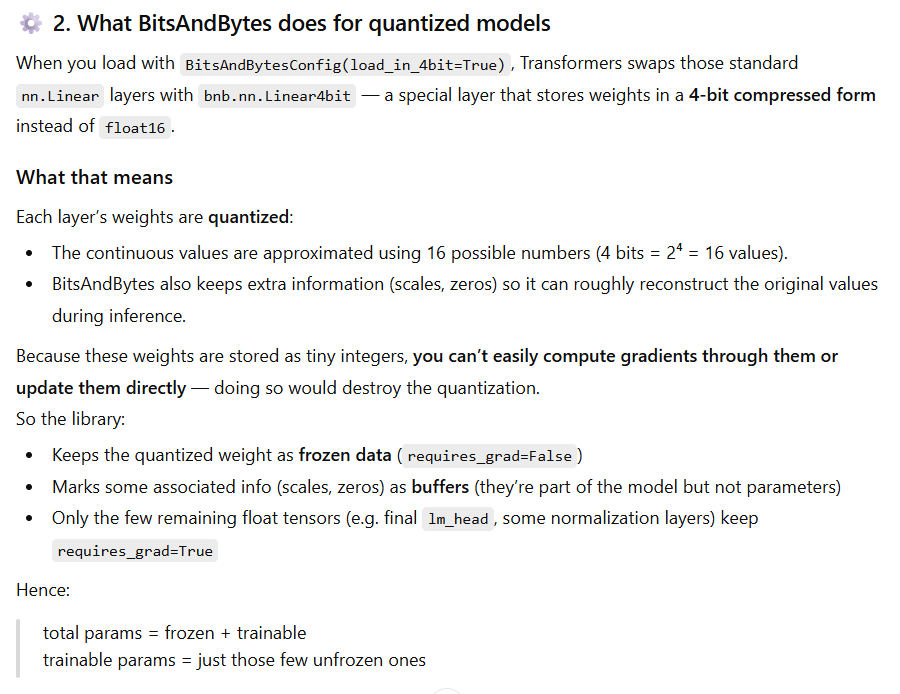

In [6]:
total_param = sum(p.numel() for p in model.parameters())
trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Model Parameters: ",total_param)
print("Total Model Trainable Parameters: ",trainable_param)

Total Model Parameters:  749275136
Total Model Trainable Parameters:  262735872


In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
non_quantized_model = AutoModelForCausalLM.from_pretrained(model_id, device_map='auto')

## Original model's number of parameters

In [8]:
print(non_quantized_model)
total_param = sum(p.numel() for p in non_quantized_model.parameters())
trainable_param = sum(p.numel() for p in non_quantized_model.parameters() if p.requires_grad)
print("Total Model Parameters: ",total_param)
print("Total Model Trainable Parameters: ",trainable_param)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (ro

## Sample Prompt to test the model's response, to demonstrate the weakness of a base model when given prompts in (Instruction: Response) format.

In [14]:
inputs = tokenizer(f"Instruction:\n How does Large Language Models respond to queries? \n\nResponse:\n", return_tensors='pt').to('cuda')
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Instruction:
 How does Large Language Models respond to queries? 

Response:
 We see that, for a given query, the model generates a text that is a mixture of the query and the generated text. 
 We also see that the generated text contains a few words from the query, which is a good sign that the model is learning from the query. 
 In fact, we see that the model generates a text that is a mixture of the query and the generated text, which means that the model is learning from the query. 
 However, the model also generates a text


In [15]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [16]:
total_param = sum(p.numel() for p in model.parameters())
trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Model Parameters: ",total_param)
print("Total Model Trainable Parameters: ",trainable_param)

Total Model Parameters:  749275136
Total Model Trainable Parameters:  0


In [17]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

# This demonstrates the trainable parameter reduction by applying LoRA Adapters

In [18]:
total_param = sum(p.numel() for p in model.parameters())
trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_param:,}")
print(f"Trainable parameters: {trainable_param:,}")

Total parameters: 754,911,232
Trainable parameters: 5,636,096


In [18]:
print(tokenizer.get_chat_template())

ValueError: Cannot use chat template functions because tokenizer.chat_template is not set and no template argument was passed! For information about writing templates and setting the tokenizer.chat_template attribute, please see the documentation at https://huggingface.co/docs/transformers/main/en/chat_templating

In [19]:
from datasets import load_dataset

# Load only the training split directly
data = load_dataset("databricks/databricks-dolly-15k", split="train")

tokenizer.pad_token = tokenizer.eos_token

def combine(example):
    if example["context"]:
        prompt = f"Context:\n{example['context']}\n\nInstruction:\n{example['instruction']}\n\nResponse:\n{example['response']}"
    else:
        prompt = f"Instruction:\n{example['instruction']}\n\nResponse:\n{example['response']}"
    return {"text": prompt}

# Filter out empty responses
data = data.filter(lambda x: x["response"] is not None and len(x["response"]) > 0)

# Apply formatting
data = data.map(combine, remove_columns=data.column_names)

# ✅ After this, data has only one column: "text"
print(data[0]["text"])

README.md: 0.00B [00:00, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15011 [00:00<?, ? examples/s]

Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

Context:
Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.

Instruction:
When did Virgin Australia start operating?

Response:
Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.


In [20]:
print(data.column_names)

['text']


In [21]:
pip show trl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: trl
Version: 0.25.0
Summary: Train transformer language models with reinforcement learning.
Home-page: https://github.com/huggingface/trl
Author: 
Author-email: Leandro von Werra <leandro.vonwerra@gmail.com>
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: accelerate, datasets, transformers
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [26]:
!pip install wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [35]:
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("WANDB_SECRET")
status = wandb.login(key=wandb_api_key)
if (status):
    print('Successfully logged into W&B')
else:
    print('Unable to log into W&B')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wkenji02 (eezzh-universiti-tunku-abdul-rahman) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Successfully logged into W&B


In [36]:
import wandb
wandb.init(
    project="my-llm-finetune",
    name="llama3-2b-dolly15k-run1",
)

In [40]:
from trl import SFTTrainer, SFTConfig

# SFT config
sft_config = SFTConfig(
    output_dir="llama3.2-1b-dolly15k-qlora",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    num_train_epochs=1,
    fp16=True,
    packing=False,
    report_to="wandb",
)

In [41]:
trainer = SFTTrainer(
    model=model,
    train_dataset=data,
    args=sft_config,
)

trainer.train()
trainer.save_model()                 # saves LoRA adapters in output_dir

Step,Training Loss
10,1.933800
20,1.807100
30,1.887400
40,1.940200
50,1.925600
60,1.863200
70,1.910300
80,1.858300
90,1.845400
100,1.942000


## Quick inference test (base + adapters)

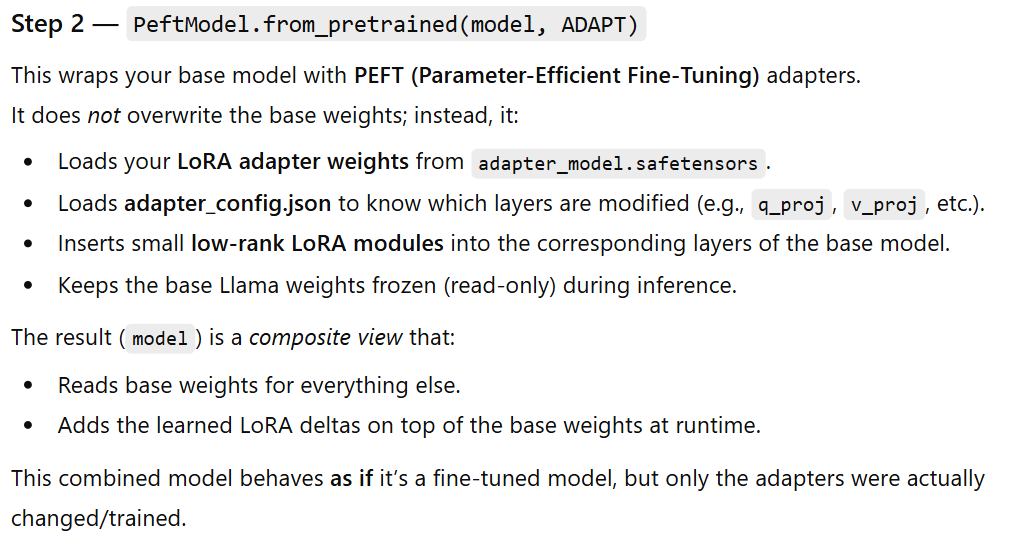
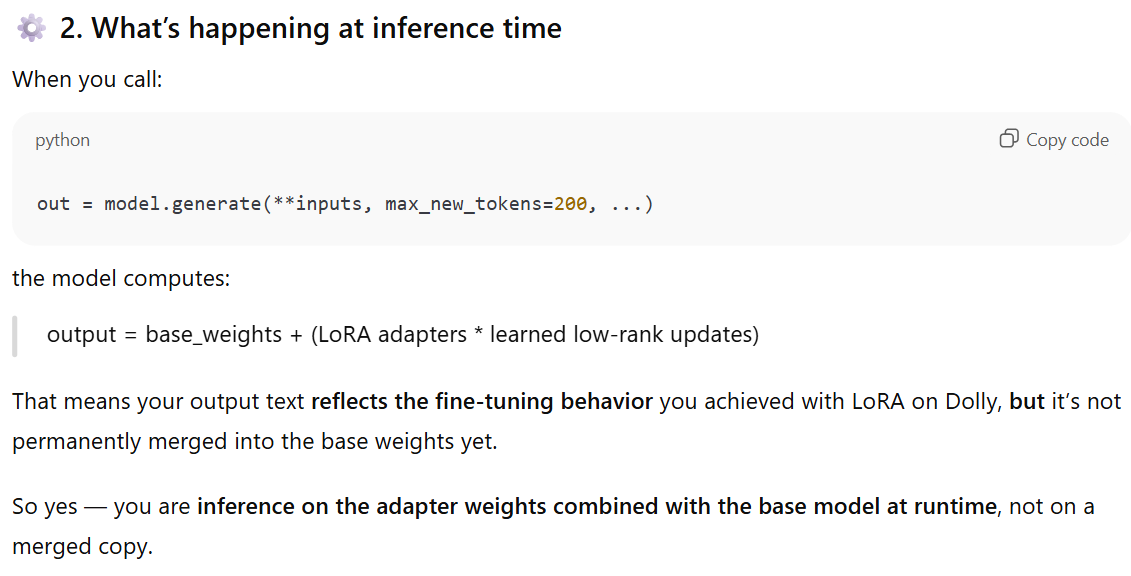
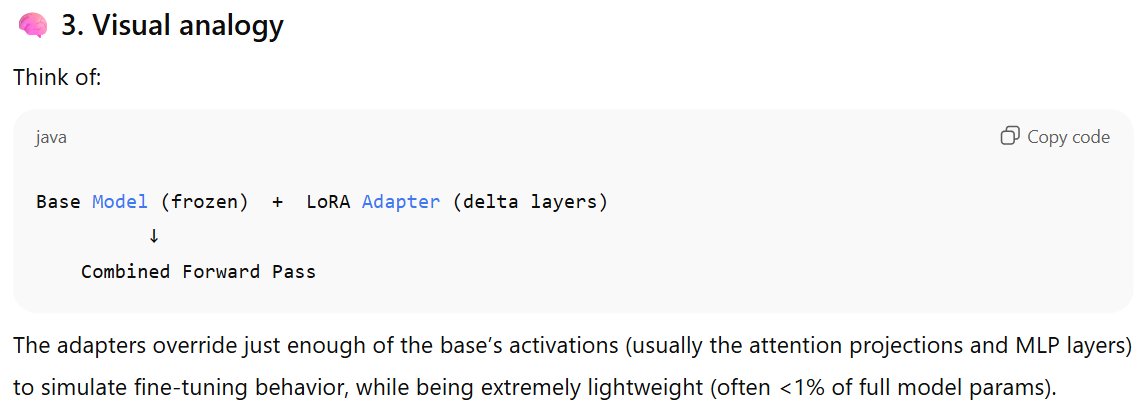

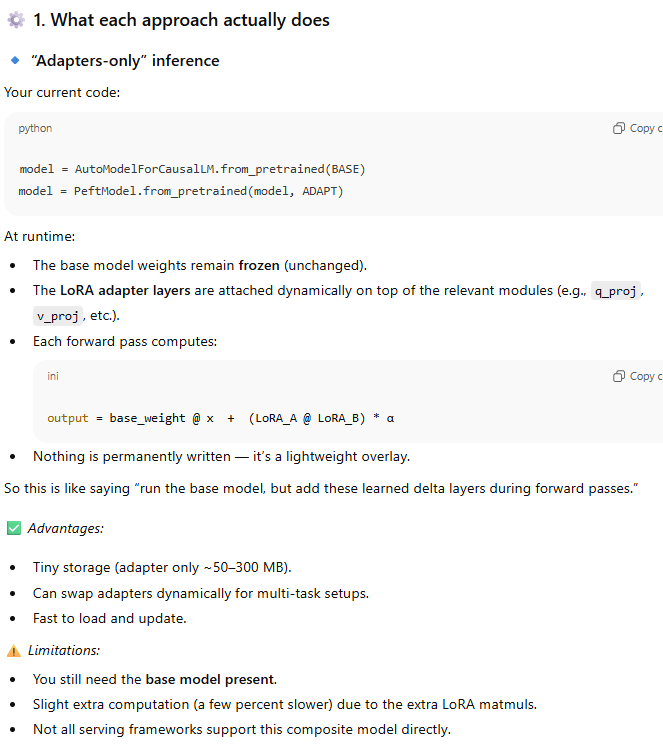
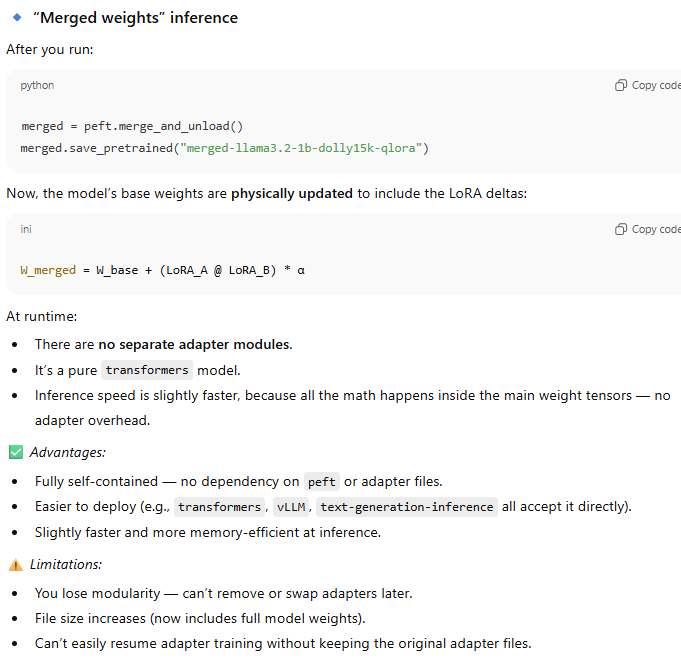
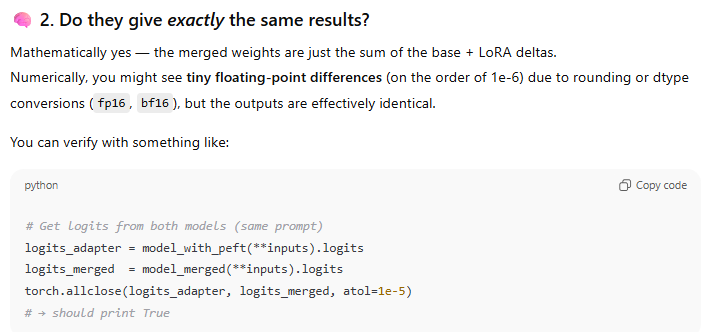
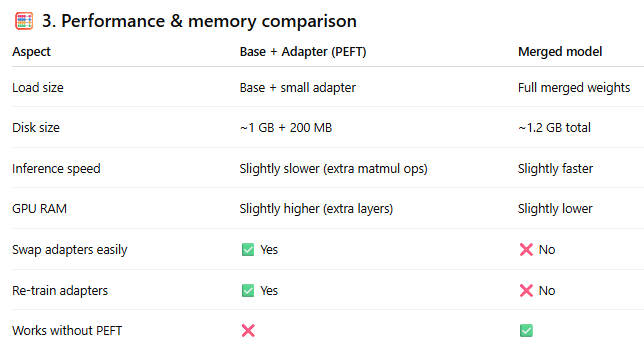

In [42]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch, os

BASE = "meta-llama/Llama-3.2-1B"
ADAPT = "/kaggle/working/llama3.2-1b-dolly15k-qlora"

# optional: sanity-check the files exist
for f in ["adapter_config.json", "adapter_model.safetensors"]:
    assert os.path.exists(os.path.join(ADAPT, f)), f"Missing {f} in {ADAPT}"

tokenizer = AutoTokenizer.from_pretrained(BASE)
model = AutoModelForCausalLM.from_pretrained(
    BASE, 
    dtype=torch.bfloat16, 
    device_map="auto"
)
model = PeftModel.from_pretrained(model, ADAPT)

prompt = "How does Large Language Models respond to queries?"
text   = f"Instruction:\n{prompt}\n\nResponse:\n"
inputs = tokenizer([text], return_tensors="pt").to(model.device)
out    = model.generate(**inputs, max_new_tokens=200, do_sample=True, top_p=0.9, temperature=0.7)
print(tokenizer.decode(out[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Instruction:
How does Large Language Models respond to queries?

Response:
Large Language Models (LLMs) are trained on large amounts of text, and are able to learn to respond to natural language queries. However, LLMs can be trained to respond to a wide range of queries, and may not always be able to provide the most appropriate response for a given query. Additionally, LLMs may not be able to handle all types of queries, and may respond with unexpected or incorrect answers.


## Merge adapters into a single checkpoint for demos

In [44]:
base = AutoModelForCausalLM.from_pretrained(BASE, dtype=torch.bfloat16)
peft = PeftModel.from_pretrained(base, ADAPT)
merged = peft.merge_and_unload()    # merges LoRA weights into base
merged.save_pretrained("merged-llama3.2-1b-dolly15k-qlora")

In [43]:
!tar -cf merged-llama3.2-1b-dolly15k-qlora.tar merged-llama3.2-1b-dolly15k-qlora

ERROR! Session/line number was not unique in database. History logging moved to new session 29
tar: merged-llama3.2-1b-dolly15k-qlora: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [45]:
print(os.listdir("merged-llama3.2-1b-dolly15k-qlora"))

['model.safetensors', 'config.json', 'generation_config.json']


In [46]:
from huggingface_hub import login, whoami
try:
    token = getpass("Hugging Face token: ")
    login(token)
    print("Login succesful.")
except Exception as e:
    print(f"Login Failed: {e}")

Hugging Face token:  ········


Login succesful.


In [47]:
from huggingface_hub import create_repo, HfApi

# ----- upload -----
repo_id = "Kenjiii/llama3.2-1b-dolly15k-qlora"   # <-- change this

create_repo(repo_id, private=False)  # or True for a private repo

api = HfApi()
api.upload_folder(
    folder_path="merged-llama3.2-1b-dolly15k-qlora",
    repo_id=repo_id,
    commit_message="Upload merged Llama-3.2-1B Dolly-15k QLoRA model"
)

print(f"Uploaded to https://huggingface.co/{repo_id}")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploaded to https://huggingface.co/Kenjiii/llama3.2-1b-dolly15k-qlora


In [48]:
from transformers import AutoTokenizer
from huggingface_hub import HfApi

repo_id = "Kenjiii/llama3.2-1b-dolly15k-qlora"

tok = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
tok.push_to_hub(repo_id)  # uploads tokenizer.json, tokenizer_config.json, etc.

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/Kenjiii/llama3.2-1b-dolly15k-qlora/commit/27f36444293e248ddb73e86c04b774de1353f718', commit_message='Upload tokenizer', commit_description='', oid='27f36444293e248ddb73e86c04b774de1353f718', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Kenjiii/llama3.2-1b-dolly15k-qlora', endpoint='https://huggingface.co', repo_type='model', repo_id='Kenjiii/llama3.2-1b-dolly15k-qlora'), pr_revision=None, pr_num=None)

In [49]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(


In [50]:
model.push_to_hub("Kenjiii/llama3.2-1b-dolly15k-qlora-adapter")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/Kenjiii/llama3.2-1b-dolly15k-qlora-adapter/commit/c9f0f5e110ed5fc6c8afa8cbaefd3711fb51a629', commit_message='Upload model', commit_description='', oid='c9f0f5e110ed5fc6c8afa8cbaefd3711fb51a629', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Kenjiii/llama3.2-1b-dolly15k-qlora-adapter', endpoint='https://huggingface.co', repo_type='model', repo_id='Kenjiii/llama3.2-1b-dolly15k-qlora-adapter'), pr_revision=None, pr_num=None)

In [52]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

# 1. Define quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
)

# 2. Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-1B",
    quantization_config=bnb_config,
    device_map="auto",
)

# 3. Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")

# 4. Load your adapter
model = PeftModel.from_pretrained(base_model, "Kenjiii/llama3.2-1b-dolly15k-qlora-adapter")

# 5. Generate text
prompt = "Explain the importance of transfer learning in AI."
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs_adapter = model.generate(**inputs, max_new_tokens=150)
print(tokenizer.decode(outputs_adapter[0], skip_special_tokens=True))

adapter_config.json: 0.00B [00:00, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Explain the importance of transfer learning in AI. How can we apply transfer learning to solve real-world problems?

Transfer learning is the process of applying knowledge from a source domain to a target domain. In the field of AI, transfer learning is used to solve a problem by reusing the knowledge from another problem domain. This allows for the use of less data and fewer parameters for the target domain. Transfer learning can be applied to a variety of tasks, including image classification, natural language processing, and machine learning.


In [53]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load base model (quantized if applicable)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
)
base_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-1B",
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")

# 2. Load adapter model (base + adapter)
adapter_model = PeftModel.from_pretrained(
    base_model,
    "Kenjiii/llama3.2-1b-dolly15k-qlora-adapter"
).to(device)

base_model.to(device)

# 3. Define prompt
prompt = "Explain the importance of transfer learning in AI."

# 4. Tokenize
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# 5. Generate with base
with torch.no_grad():
    outputs_base = base_model.generate(**inputs, max_new_tokens=150)
decode_base = tokenizer.decode(outputs_base[0], skip_special_tokens=True)

# 6. Generate with adapter
with torch.no_grad():
    outputs_adapter = adapter_model.generate(**inputs, max_new_tokens=150)
decode_adapter = tokenizer.decode(outputs_adapter[0], skip_special_tokens=True)

# 7. Compare results
print("PROMPT:", prompt)
print("BASE MODEL OUTPUT:\n", decode_base)
print("-" * 80)
print("ADAPTER MODEL OUTPUT:\n", decode_adapter)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


PROMPT: Explain the importance of transfer learning in AI.
BASE MODEL OUTPUT:
 Explain the importance of transfer learning in AI. Provide a list of transfer learning techniques.
Transfer learning is a type of machine learning that uses knowledge from a previous task to train a new task. This knowledge is called transfer learning, and it can be used to improve the performance of a new task in a way that is similar to how humans learn.
Transfer learning is a type of machine learning that uses knowledge from a previous task to train a new task. This knowledge is called transfer learning, and it can be used to improve the performance of a new task in a way that is similar to how humans learn. Transfer learning is used in a variety of applications, including computer vision, natural language processing, and reinforcement learning. In computer vision, for example, transfer learning can be used to improve the performance
------------------------------------------------------------------------